In [1]:
import tensorflow as tf
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time

2024-01-12 15:11:58.325514: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-12 15:11:58.650510: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-12 15:11:58.652728: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-12 15:11:59.972710: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def remove_number_and_period(s):
    return re.sub(r'\.\d+$', '', s)

def concat(file_paths):
    matrix_archea = pd.read_csv(file_paths[0], sep="\t", index_col=0) 
    matrix_bacteria = pd.read_csv(file_paths[1], sep="\t", index_col=0)
    matrix = pd.concat([matrix_archea,matrix_bacteria]) 
    matrix = matrix.fillna(0)
    matrix = matrix.div(matrix.sum(axis=1), axis=0)
    shuffled_index = np.random.permutation(matrix.index)
    shuffled_matrix = matrix.reindex(shuffled_index)
    labels = shuffled_matrix.index
    correct_labels = [remove_number_and_period(s) for s in labels]
    shuffled_matrix.index = correct_labels
    unique_labels = set(correct_labels)
    final_labels = list(unique_labels)
    num_classes = len(final_labels)
    num_kmers = shuffled_matrix.shape[1]
    label_encoder = LabelEncoder()
    integer_encoded_labels = label_encoder.fit_transform(correct_labels)
    integer_encoded_labels = integer_encoded_labels.flatten().tolist()
    return shuffled_matrix.values,  integer_encoded_labels , num_classes, num_kmers
    

def create_cnn_model(num_rows, num_classes, num_kmers):
    model = Sequential([
    Conv1D(filters=100, kernel_size=3, activation='relu', input_shape=(num_kmers, 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
      ])
    return model


def main(files_paths):    
    # Generate compact matrices for each file
    combined_data, labels, num_classes, num_kmers = concat(file_paths)
    # Reshape the frequency matrix
    frequency_matrix = combined_data.reshape(combined_data.shape[0], combined_data.shape[1], 1)
    # Reshape the labels
    labels = np.array(labels)
    labels_one_hot = to_categorical(labels, num_classes=num_classes)
    num_rows = frequency_matrix.shape[0]
    # Perform 10-fold cross-validation
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    accuracies = []
    for train_index, test_index in kfold.split(frequency_matrix, np.argmax(labels_one_hot, axis=1)):
        X_train, X_test = frequency_matrix[train_index], frequency_matrix[test_index]
        y_train, y_test = labels_one_hot[train_index], labels_one_hot[test_index]
        # Create and compile the model
        model = create_cnn_model(num_rows=num_rows,num_classes=num_classes, num_kmers=num_kmers)
        # Compile the model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        # Train the model
        model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
        # Predict on the test set
        y_pred = np.argmax(model.predict(X_test), axis=1)
        # Calculate accuracy
        accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
        accuracies.append(accuracy)
    # Plot the accuracy
    plt.plot(accuracies, marker='o', linestyle='-', color='b')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.title('Accuracy for Each Fold in 10-Fold Cross-Validation')
    plt.show()
    print("Mean Accuracy:", np.mean(accuracies))
    return

def main2(files_paths):    
    # Generate compact matrices for each file
    combined_data, labels, num_classes, num_kmers = concat(files_paths)
    # Reshape the frequency matrix
    frequency_matrix = combined_data.reshape(combined_data.shape[0], combined_data.shape[1], 1)
    # Reshape the labels
    labels = np.array(labels)
    labels_one_hot = to_categorical(labels, num_classes=num_classes)
    num_rows = frequency_matrix.shape[0]
    # Perform 10-fold cross-validation
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    accuracies = []
    execution_times = []
    for fold_num, (train_index, test_index) in enumerate(kfold.split(frequency_matrix, np.argmax(labels_one_hot, axis=1))):
        X_train, X_test = frequency_matrix[train_index], frequency_matrix[test_index]
        y_train, y_test = labels_one_hot[train_index], labels_one_hot[test_index]
        # Create and compile the model
        model = create_cnn_model(num_rows=num_rows, num_classes=num_classes, num_kmers=num_kmers)
        # Compile the model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])        
        # Measure execution time for training
        start_time = time.time()
        model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
        end_time = time.time()
        execution_time = end_time - start_time
        execution_times.append(execution_time)        
        # Predict on the test set
        y_pred = np.argmax(model.predict(X_test), axis=1)
        # Calculate accuracy
        accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
        accuracies.append(accuracy)
    # Save accuracy information to a single file
    np.savetxt('accuracies_per_fold.txt', np.array(accuracies), delimiter=',')
    # Save execution times to file
    np.savetxt('execution_times.txt', np.array(execution_times), delimiter=',')
    # Plot the accuracy
    plt.plot(accuracies, marker='o', linestyle='-', color='b')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.title('Accuracy for Each Fold in 10-Fold Cross-Validation')
    plt.show()
    print("Mean Accuracy:", np.mean(accuracies))
    return


def fast_test(file_paths, test_size=0.2, random_state=42):    
    # Generate compact matrices for each file
    combined_data, labels, num_classes, num_kmers = concat(file_paths)
    # Reshape the frequency matrix
    frequency_matrix = combined_data.reshape(combined_data.shape[0], combined_data.shape[1], 1)
    # Reshape the labels
    labels = np.array(labels)
    labels_one_hot = to_categorical(labels, num_classes=num_classes)
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(frequency_matrix, labels_one_hot, test_size=test_size, random_state=random_state)
    num_rows = frequency_matrix.shape[0]
    # Create the CNN model
    model = Sequential([
        Conv1D(filters=100, kernel_size=3, activation='relu', input_shape=(num_kmers, 1)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Train the model on the training set
    start_time = time.time()
    model.fit(X_train, y_train, epochs=50, batch_size=32)
    end_time = time.time()  # Record end time

    # Evaluate the model on the test set
    scores = model.evaluate(X_test, y_test, verbose=0)
    print(f'Test Accuracy: {scores[1]}')
    execution_time = end_time - start_time
    print(f'Execution Time to train the model: {execution_time} seconds')
    return scores[1], execution_time

def compare_k(file_paths_3, file_paths_5, file_paths_6, file_paths_8, save_plots=True):
    accuracy_3, execution_time_3 = fast_test(file_paths_3)
    accuracy_5, execution_time_5 = fast_test(file_paths_5)
    accuracy_6, execution_time_6 = fast_test(file_paths_6)
    accuracy_8, execution_time_8 = fast_test(file_paths_8)    
    # Plotting accuracy
    plt.figure(figsize=(12, 6))
    k_values = ['3-kmers', '5-kmers', '6-kmers', '8-kmers']
    accuracy_values = [accuracy_3, accuracy_5, accuracy_6, accuracy_8]
    plt.bar(k_values, accuracy_values, color=['blue', 'orange', 'green', 'red'])
    plt.title('Accuracy Comparison for Different k Sizes')
    plt.ylabel('Accuracy')
    if save_plots:
        plt.savefig('accuracy_comparison.png')
    else:
        plt.show()    
    # Plotting execution time
    plt.figure(figsize=(12, 6))
    execution_time_values = [execution_time_3, execution_time_5, execution_time_6, execution_time_8]
    plt.bar(k_values, execution_time_values, color=['blue', 'orange', 'green', 'red'])
    plt.title('Execution Time Comparison for Different k Sizes')
    plt.ylabel('Execution Time (seconds)')
    if save_plots:
        plt.savefig('execution_time_comparison.png')
    else:
        plt.show()    
    return 


In [3]:
file_paths_3 = ["3-mer_archea_genes.csv", "3-mer_bacteria_genes.csv"]
file_paths_5 = ["5-mer_archea_genes.csv", "5-mer_bacteria_genes.csv"]
file_paths_6 = ["6-mer_archea_genes.csv", "6-mer_bacteria_genes.csv"]
file_paths_8 = ["8-mer_archea_genes.csv", "8-mer_bacteria_genes.csv"]

13/13 [==============================] - 0s 2ms/step


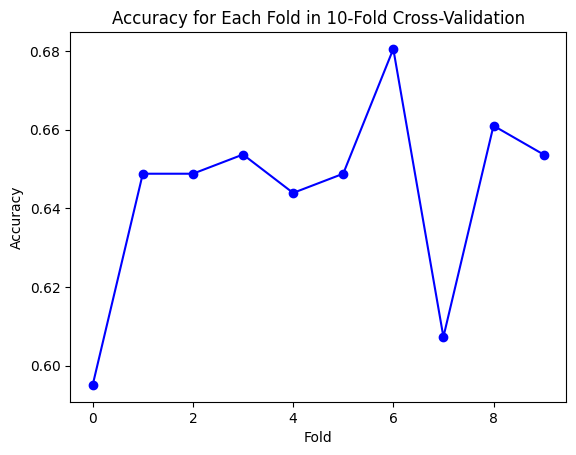

Mean Accuracy: 0.6441463414634147


In [9]:
main2(file_paths_3)

13/13 [==============================] - 0s 8ms/step


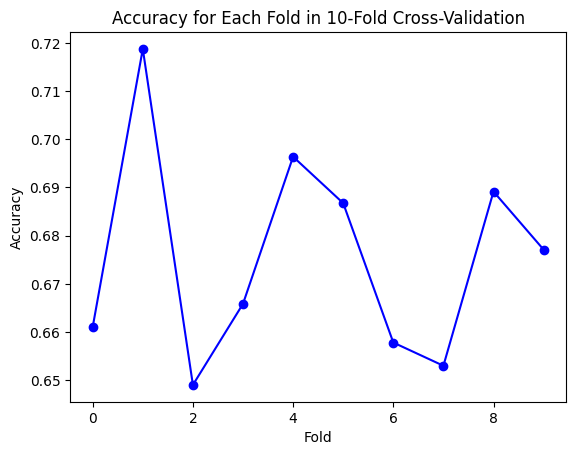

Mean Accuracy: 0.6754952502316961


In [14]:
main2(file_paths_5)

In [ ]:
main2(file_paths_6)

In [ ]:
main2(file_paths_8)